In [32]:
# Cell 1: Import Libraries
import pandas as pd
import networkx as nx
import heapq
from typing import Callable, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [33]:
# Cell 2: Load Dataset
PATH = r"C:\Users\Md Sakib\DATA_FOR_7_dAYS\dhakas_timeseries_2025-02-15_7d_15min.csv"
df = pd.read_csv(PATH, parse_dates=["timestamp"])

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Timestamp range: {df['timestamp'].min()} to {df['timestamp'].max()}")
df.head()

Dataset shape: (3360000, 10)
Columns: ['timestamp', 'u', 'v', 'key', 'road_type', 'length_m', 'free_speed_kmh', 'traffic_factor', 'current_speed_kmh', 'travel_time_seconds']
Timestamp range: 2025-02-15 00:00:00+06:00 to 2025-02-21 23:45:00+06:00


,timestamp,u,v,key,road_type,length_m,free_speed_kmh,traffic_factor,current_speed_kmh,travel_time_seconds
0,2025-02-15 00:00:00+06:00,5063403502,5063403483,0,residential,27.835,15.0,0.2469,12.04,8.32
1,2025-02-15 00:00:00+06:00,9908994079,9909890955,0,residential,240.295,15.0,0.1326,13.41,64.52
2,2025-02-15 00:00:00+06:00,387124254,387124256,0,tertiary,81.257,25.0,0.2262,20.48,14.29
3,2025-02-15 00:00:00+06:00,5608468019,5608468101,0,residential,86.750,15.0,0.4316,9.82,31.80
4,2025-02-15 00:00:00+06:00,10009255308,10009255322,0,primary,432.464,40.0,0.0799,37.44,41.58


In [34]:
# Cell 3: Create Edge ID
# Combine u, v, key to create a unique edge identifier
df['edge_id'] = df['u'].astype(str) + '_' + df['v'].astype(str) + '_' + df['key'].astype(str)

print(f"Unique edges: {df['edge_id'].nunique()}")
print(f"Unique timestamps: {df['timestamp'].nunique()}")
df[['edge_id', 'u', 'v', 'key']].head()

Unique edges: 5000
Unique timestamps: 672


,edge_id,u,v,key
0,5063403502_5063403483_0,5063403502,5063403483,0
1,9908994079_9909890955_0,9908994079,9909890955,0
2,387124254_387124256_0,387124254,387124256,0
3,5608468019_5608468101_0,5608468019,5608468101,0
4,10009255308_10009255322_0,10009255308,10009255322,0


In [35]:
# Cell 4: Build MultiDiGraph with Static Attributes
def build_graph(df: pd.DataFrame) -> nx.MultiDiGraph:
    """
    Build a NetworkX MultiDiGraph from the dataframe.
    Uses the first timestamp's data as initial edge attributes.
    """
    G = nx.MultiDiGraph()
    
    # Get unique edges (first occurrence for static attributes)
    edges_static = df.drop_duplicates(subset=['u', 'v', 'key']).copy()
    
    for _, row in edges_static.iterrows():
        G.add_edge(
            row['u'], 
            row['v'], 
            key=row['key'],
            edge_id=row['edge_id'],
            road_type=row['road_type'],
            length_m=row['length_m'],
            free_speed_kmh=row['free_speed_kmh'],
            # Dynamic attributes (will be updated per timestamp)
            traffic_factor=row['traffic_factor'],
            current_speed_kmh=row['current_speed_kmh'],
            travel_time_seconds=row['travel_time_seconds'],
            # Pre-compute free flow travel time
            free_time_s=row['length_m'] / (row['free_speed_kmh'] * 1000 / 3600)
        )
    
    return G

G = build_graph(df)
print(f"Graph nodes: {G.number_of_nodes()}")
print(f"Graph edges: {G.number_of_edges()}")

Graph nodes: 9567
Graph edges: 5000


In [38]:
# Cell 5: Create Timestamp Lookup Dictionary
def create_timestamp_lookup(df: pd.DataFrame) -> dict:
    """
    Create a dictionary for fast lookup of edge attributes by timestamp.
    Structure: {timestamp: {(u, v, key): {attributes}}}
    """
    lookup = {}
    
    for ts, group in df.groupby('timestamp'):
        lookup[ts] = {}
        for _, row in group.iterrows():
            lookup[ts][(row['u'], row['v'], row['key'])] = {
                'traffic_factor': row['traffic_factor'],
                'current_speed_kmh': row['current_speed_kmh'],
                'travel_time_seconds': row['travel_time_seconds']
            }
    
    return lookup

timestamp_lookup = create_timestamp_lookup(df)
timestamps = sorted(timestamp_lookup.keys())
print(f"Timestamps indexed: {len(timestamps)}")
print(f"First timestamp: {timestamps[0]}")
print(f"Last timestamp: {timestamps[-1]}")

Timestamps indexed: 672
First timestamp: 2025-02-15 00:00:00+06:00
Last timestamp: 2025-02-21 23:45:00+06:00


In [39]:
# Cell 6: Update Graph at Timestamp
def update_graph_at_timestamp(G: nx.MultiDiGraph, timestamp: pd.Timestamp, 
                               lookup: dict) -> nx.MultiDiGraph:
    """
    Update graph edge attributes for a specific timestamp.
    Returns the updated graph.
    """
    if timestamp not in lookup:
        available = list(lookup.keys())[:3]
        raise ValueError(f"Timestamp {timestamp} not found. Available: {available}...")
    
    ts_data = lookup[timestamp]
    
    for u, v, key, data in G.edges(keys=True, data=True):
        edge_key = (u, v, key)
        if edge_key in ts_data:
            attrs = ts_data[edge_key]
            data['traffic_factor'] = attrs['traffic_factor']
            data['current_speed_kmh'] = attrs['current_speed_kmh']
            data['travel_time_seconds'] = attrs['travel_time_seconds']
    
    return G

# Test the function
test_ts = timestamps[0]
G = update_graph_at_timestamp(G, test_ts, timestamp_lookup)
print(f"Graph updated for timestamp: {test_ts}")

Graph updated for timestamp: 2025-02-15 00:00:00+06:00


In [40]:
# Cell 7: Define Cost Functions
def cost_free_time(u: int, v: int, data: dict) -> float:
    """Cost based on free flow travel time (no traffic)."""
    return data.get('free_time_s', data['length_m'] / (data['free_speed_kmh'] * 1000 / 3600))

def cost_travel_time(u: int, v: int, data: dict) -> float:
    """Cost based on current travel time (with traffic)."""
    return data.get('travel_time_seconds', data['length_m'] / (data['current_speed_kmh'] * 1000 / 3600))

def cost_llm(u: int, v: int, data: dict) -> float:
    """
    LLM-inspired cost function combining multiple factors:
    - Base travel time with traffic
    - Penalty for congestion (traffic_factor > 1)
    - Preference for major roads (lower penalty)
    """
    base_time = data.get('travel_time_seconds', 0)
    traffic_factor = data.get('traffic_factor', 1.0)
    road_type = data.get('road_type', 'residential')
    
    # Road type weights (prefer highways/primary roads)
    road_weights = {
        'motorway': 0.8,
        'trunk': 0.85,
        'primary': 0.9,
        'secondary': 0.95,
        'tertiary': 1.0,
        'residential': 1.1,
        'unclassified': 1.15
    }
    road_weight = road_weights.get(road_type, 1.0)
    
    # Congestion penalty (exponential for heavy traffic)
    congestion_penalty = 1.0 + max(0, (traffic_factor - 1) * 0.5)
    
    return base_time * road_weight * congestion_penalty

print("Cost functions defined:")
print("  - cost_free_time: Free flow travel time")
print("  - cost_travel_time: Current travel time with traffic")
print("  - cost_llm: LLM-style weighted cost")

Cost functions defined:
  - cost_free_time: Free flow travel time
  - cost_travel_time: Current travel time with traffic
  - cost_llm: LLM-style weighted cost


In [41]:
# Cell 8: Generic Path Cost Calculator
def path_cost(G: nx.MultiDiGraph, path: List[int], 
              cost_func: Callable[[int, int, dict], float]) -> float:
    """
    Calculate total cost of a path using a given cost function.
    
    Args:
        G: NetworkX MultiDiGraph
        path: List of node IDs representing the path
        cost_func: Function(u, v, edge_data) -> float
    
    Returns:
        Total cost of the path
    """
    if len(path) < 2:
        return 0.0
    
    total_cost = 0.0
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        
        # For MultiDiGraph, get the edge with minimum cost
        if G.has_edge(u, v):
            edges = G.get_edge_data(u, v)
            min_cost = min(cost_func(u, v, data) for data in edges.values())
            total_cost += min_cost
        else:
            return float('inf')  # Path broken
    
    return total_cost

print("path_cost function defined")

path_cost function defined


In [42]:
# Cell 9: Dijkstra Shortest Path with Custom Weight Function
def dijkstra_path(G: nx.MultiDiGraph, source: int, target: int,
                  cost_func: Callable[[int, int, dict], float]) -> Tuple[List[int], float]:
    """
    Find shortest path using Dijkstra's algorithm with custom cost function.
    
    Args:
        G: NetworkX MultiDiGraph
        source: Source node ID
        target: Target node ID
        cost_func: Function(u, v, edge_data) -> float
    
    Returns:
        Tuple of (path as list of nodes, total cost)
    """
    # Distance dictionary
    dist = {source: 0}
    prev = {source: None}
    visited = set()
    
    # Priority queue: (cost, node)
    pq = [(0, source)]
    
    while pq:
        current_dist, u = heapq.heappop(pq)
        
        if u in visited:
            continue
        visited.add(u)
        
        if u == target:
            break
        
        # Explore neighbors
        for v in G.successors(u):
            if v in visited:
                continue
            
            # Get minimum cost edge between u and v
            edges = G.get_edge_data(u, v)
            edge_cost = min(cost_func(u, v, data) for data in edges.values())
            
            new_dist = current_dist + edge_cost
            
            if v not in dist or new_dist < dist[v]:
                dist[v] = new_dist
                prev[v] = u
                heapq.heappush(pq, (new_dist, v))
    
    # Reconstruct path
    if target not in prev:
        return [], float('inf')
    
    path = []
    node = target
    while node is not None:
        path.append(node)
        node = prev[node]
    path.reverse()
    
    return path, dist.get(target, float('inf'))

print("dijkstra_path function defined")

dijkstra_path function defined


In [43]:
# Cell 10: Compute All Three Paths
def compute_all_paths(G: nx.MultiDiGraph, source: int, target: int) -> dict:
    """
    Compute paths using all three cost functions.
    
    Returns:
        Dictionary with path info for each cost function
    """
    results = {}
    
    # 1. Free flow time path
    path_free, cost_free = dijkstra_path(G, source, target, cost_free_time)
    results['free_time'] = {
        'path': path_free,
        'free_time_s': cost_free,
        'travel_time_s': path_cost(G, path_free, cost_travel_time),
        'llm_cost_s': path_cost(G, path_free, cost_llm),
        'num_edges': len(path_free) - 1 if path_free else 0
    }
    
    # 2. Current travel time path
    path_travel, cost_travel = dijkstra_path(G, source, target, cost_travel_time)
    results['travel_time'] = {
        'path': path_travel,
        'free_time_s': path_cost(G, path_travel, cost_free_time),
        'travel_time_s': cost_travel,
        'llm_cost_s': path_cost(G, path_travel, cost_llm),
        'num_edges': len(path_travel) - 1 if path_travel else 0
    }
    
    # 3. LLM-weighted path
    path_llm, cost_llm_val = dijkstra_path(G, source, target, cost_llm)
    results['llm_weighted'] = {
        'path': path_llm,
        'free_time_s': path_cost(G, path_llm, cost_free_time),
        'travel_time_s': path_cost(G, path_llm, cost_travel_time),
        'llm_cost_s': cost_llm_val,
        'num_edges': len(path_llm) - 1 if path_llm else 0
    }
    
    return results

print("compute_all_paths function defined")

compute_all_paths function defined


In [44]:
# Cell 11: Display Results Helper
def display_results(results: dict, source: int, target: int, timestamp: pd.Timestamp):
    """Pretty print routing results."""
    print("=" * 70)
    print(f"ROUTING RESULTS: {source} → {target}")
    print(f"Timestamp: {timestamp}")
    print("=" * 70)
    
    for method, data in results.items():
        print(f"\n📍 {method.upper().replace('_', ' ')} PATH:")
        print(f"   Edges: {data['num_edges']}")
        print(f"   Free Time:   {data['free_time_s']:.2f} sec ({data['free_time_s']/60:.2f} min)")
        print(f"   Travel Time: {data['travel_time_s']:.2f} sec ({data['travel_time_s']/60:.2f} min)")
        print(f"   LLM Cost:    {data['llm_cost_s']:.2f} sec ({data['llm_cost_s']/60:.2f} min)")
        
        # Show delay due to traffic
        delay = data['travel_time_s'] - data['free_time_s']
        delay_pct = (delay / data['free_time_s'] * 100) if data['free_time_s'] > 0 else 0
        print(f"   Traffic Delay: {delay:.2f} sec ({delay_pct:.1f}%)")
    
    print("\n" + "=" * 70)

print("display_results function defined")

display_results function defined


In [45]:
# Cell 12: Get Largest Weakly Connected Component & Build Subgraph
def get_largest_wcc_subgraph(G: nx.MultiDiGraph) -> nx.MultiDiGraph:
    """
    Extract the largest weakly connected component from the graph.
    Returns a subgraph containing only nodes in the largest WCC.
    """
    if G.number_of_nodes() == 0:
        raise ValueError("Graph is empty!")
    
    # Get all weakly connected components
    wccs = list(nx.weakly_connected_components(G))
    print(f"Found {len(wccs)} weakly connected components")
    
    # Find the largest WCC
    largest_wcc = max(wccs, key=len)
    print(f"Largest WCC has {len(largest_wcc)} nodes ({len(largest_wcc)/G.number_of_nodes()*100:.1f}% of graph)")
    
    # Build subgraph
    G_sub = G.subgraph(largest_wcc).copy()
    print(f"Subgraph: {G_sub.number_of_nodes()} nodes, {G_sub.number_of_edges()} edges")
    
    return G_sub

# Extract largest WCC
G = get_largest_wcc_subgraph(G)

# Update the timestamp lookup to only include edges in subgraph
def filter_lookup_for_subgraph(lookup: dict, G: nx.MultiDiGraph) -> dict:
    """Filter timestamp lookup to only include edges present in subgraph."""
    edge_set = set((u, v, k) for u, v, k in G.edges(keys=True))
    filtered = {}
    for ts, edges in lookup.items():
        filtered[ts] = {k: v for k, v in edges.items() if k in edge_set}
    return filtered

timestamp_lookup = filter_lookup_for_subgraph(timestamp_lookup, G)
print(f"Timestamp lookup filtered for subgraph")

Found 4605 weakly connected components
Largest WCC has 5 nodes (0.1% of graph)
Subgraph: 5 nodes, 4 edges
Timestamp lookup filtered for subgraph


In [46]:
# Cell 13: Select Source & Target with Minimum Hops Guarantee
import random

def find_valid_src_dst(G: nx.MultiDiGraph, min_hops: int = 2, 
                       max_attempts: int = 100, seed: int = 42) -> Tuple[int, int]:
    """
    Find source and destination nodes with a valid path of at least min_hops.
    
    Args:
        G: NetworkX MultiDiGraph (should be from largest WCC)
        min_hops: Minimum number of edges in the path
        max_attempts: Maximum random sampling attempts
        seed: Random seed for reproducibility
    
    Returns:
        Tuple of (source_node, target_node)
    
    Raises:
        ValueError if no valid pair found after max_attempts
    """
    random.seed(seed)
    nodes = list(G.nodes())
    
    if len(nodes) < min_hops + 1:
        raise ValueError(f"Graph has only {len(nodes)} nodes, need at least {min_hops + 1}")
    
    for attempt in range(max_attempts):
        src = random.choice(nodes)
        dst = random.choice(nodes)
        
        if src == dst:
            continue
        
        try:
            # Use NetworkX's built-in shortest path (unweighted = hop count)
            path = nx.shortest_path(G, src, dst)
            hop_count = len(path) - 1
            
            if hop_count >= min_hops:
                print(f"✓ Found valid pair on attempt {attempt + 1}")
                print(f"  Source: {src}, Target: {dst}")
                print(f"  Shortest path hops: {hop_count}")
                return src, dst
                
        except nx.NetworkXNoPath:
            continue
    
    raise ValueError(f"Could not find valid src/dst pair with {min_hops}+ hops after {max_attempts} attempts")


def find_valid_src_dst_robust(G: nx.MultiDiGraph, min_hops: int = 2, 
                               seed: int = 42) -> Tuple[int, int]:
    """
    Robust version: Uses BFS to find nodes at distance >= min_hops.
    Fallback to any reachable pair if min_hops constraint cannot be met.
    """
    random.seed(seed)
    nodes = list(G.nodes())
    random.shuffle(nodes)
    
    best_pair = None
    best_hops = 0
    
    # Try multiple source nodes
    for src in nodes[:min(20, len(nodes))]:  # Sample up to 20 sources
        # BFS to find distances from src
        distances = nx.single_source_shortest_path_length(G, src)
        
        # Find nodes at distance >= min_hops
        far_nodes = [n for n, d in distances.items() if d >= min_hops]
        
        if far_nodes:
            dst = random.choice(far_nodes)
            print(f"✓ Found valid pair with {distances[dst]} hops")
            print(f"  Source: {src}, Target: {dst}")
            return src, dst
        
        # Track best fallback
        if distances:
            max_dist_node = max(distances.items(), key=lambda x: x[1])
            if max_dist_node[1] > best_hops:
                best_hops = max_dist_node[1]
                best_pair = (src, max_dist_node[0])
    
    # Fallback: return best pair found
    if best_pair and best_pair[0] != best_pair[1]:
        print(f"⚠ Fallback: Best pair has {best_hops} hops (less than requested {min_hops})")
        print(f"  Source: {best_pair[0]}, Target: {best_pair[1]}")
        return best_pair
    
    raise ValueError("Could not find any valid source/destination pair")


# Find source and target with minimum 2 hops
MIN_HOPS = 2
try:
    source_node, target_node = find_valid_src_dst_robust(G, min_hops=MIN_HOPS, seed=42)
except ValueError as e:
    print(f"Error: {e}")
    # Ultimate fallback: just pick first two different nodes
    nodes = list(G.nodes())
    source_node, target_node = nodes[0], nodes[min(1, len(nodes)-1)]
    print(f"Ultimate fallback: src={source_node}, dst={target_node}")

print(f"\n📍 Selected: {source_node} → {target_node}")

✓ Found valid pair with 2 hops
  Source: 1794726803, Target: 10027894562

📍 Selected: 1794726803 → 10027894562


In [47]:
# Cell 14: Run Routing for a Specific Timestamp (with path validation)
def safe_route(G: nx.MultiDiGraph, source: int, target: int, 
               timestamp: pd.Timestamp, lookup: dict) -> Optional[dict]:
    """
    Safely compute routes with fallback for disconnected nodes.
    """
    # First check if path exists
    if not nx.has_path(G, source, target):
        print(f"⚠ No path exists between {source} and {target}")
        return None
    
    # Update graph for timestamp
    G = update_graph_at_timestamp(G, timestamp, lookup)
    
    # Compute paths
    results = compute_all_paths(G, source, target)
    
    # Validate results
    for method, data in results.items():
        if not data['path']:
            print(f"⚠ {method} returned empty path")
    
    return results

# Select a timestamp
selected_timestamp = timestamps[0]

# Run safe routing
results = safe_route(G, source_node, target_node, selected_timestamp, timestamp_lookup)

if results:
    display_results(results, source_node, target_node, selected_timestamp)
else:
    print("Routing failed - try different source/target nodes")

ROUTING RESULTS: 1794726803 → 10027894562
Timestamp: 2025-02-15 00:00:00+06:00

📍 FREE TIME PATH:
   Edges: 2
   Free Time:   80.92 sec (1.35 min)
   Travel Time: 88.09 sec (1.47 min)
   LLM Cost:    96.90 sec (1.61 min)
   Traffic Delay: 7.17 sec (8.9%)

📍 TRAVEL TIME PATH:
   Edges: 2
   Free Time:   80.92 sec (1.35 min)
   Travel Time: 88.09 sec (1.47 min)
   LLM Cost:    96.90 sec (1.61 min)
   Traffic Delay: 7.17 sec (8.9%)

📍 LLM WEIGHTED PATH:
   Edges: 2
   Free Time:   80.92 sec (1.35 min)
   Travel Time: 88.09 sec (1.47 min)
   LLM Cost:    96.90 sec (1.61 min)
   Traffic Delay: 7.17 sec (8.9%)



In [48]:
# Cell 15: Compare Paths Across Different Timestamps
def compare_timestamps(G: nx.MultiDiGraph, source: int, target: int,
                       timestamps_to_compare: List[pd.Timestamp],
                       lookup: dict) -> pd.DataFrame:
    """
    Compare routing results across multiple timestamps.
    Handles cases where path may not exist.
    """
    # Validate path exists first
    if not nx.has_path(G, source, target):
        print(f"⚠ No path between {source} and {target}")
        return pd.DataFrame()
    
    records = []
    
    for ts in timestamps_to_compare:
        G = update_graph_at_timestamp(G, ts, lookup)
        results = compute_all_paths(G, source, target)
        
        for method, data in results.items():
            if data['path']:  # Only record if path exists
                records.append({
                    'timestamp': ts,
                    'method': method,
                    'free_time_s': data['free_time_s'],
                    'travel_time_s': data['travel_time_s'],
                    'llm_cost_s': data['llm_cost_s'],
                    'num_edges': data['num_edges'],
                    'delay_s': data['travel_time_s'] - data['free_time_s']
                })
    
    return pd.DataFrame(records)

# Compare first 5 timestamps
comparison_df = compare_timestamps(G, source_node, target_node, timestamps[:5], timestamp_lookup)
if not comparison_df.empty:
    display(comparison_df)
else:
    print("No valid paths found for comparison")

,timestamp,method,free_time_s,travel_time_s,llm_cost_s,num_edges,delay_s
0,2025-02-15 00:00:00+06:00,free_time,80.91576,88.09,96.899,2,7.17424
1,2025-02-15 00:00:00+06:00,travel_time,80.91576,88.09,96.899,2,7.17424
2,2025-02-15 00:00:00+06:00,llm_weighted,80.91576,88.09,96.899,2,7.17424
3,2025-02-15 00:15:00+06:00,free_time,80.91576,84.29,92.719,2,3.37424
4,2025-02-15 00:15:00+06:00,travel_time,80.91576,84.29,92.719,2,3.37424
5,2025-02-15 00:15:00+06:00,llm_weighted,80.91576,84.29,92.719,2,3.37424
6,2025-02-15 00:30:00+06:00,free_time,80.91576,106.84,117.524,2,25.92424
7,2025-02-15 00:30:00+06:00,travel_time,80.91576,106.84,117.524,2,25.92424
8,2025-02-15 00:30:00+06:00,llm_weighted,80.91576,106.84,117.524,2,25.92424
9,2025-02-15 00:45:00+06:00,free_time,80.91576,97.00,106.700,2,16.08424


In [49]:
# Cell 16: Dynamic Routing - Full Pipeline Function (Robust)
def dynamic_route(source: int, target: int, timestamp: pd.Timestamp,
                  G: nx.MultiDiGraph = G, lookup: dict = timestamp_lookup) -> Optional[dict]:
    """
    Main function for dynamic routing with robust error handling.
    
    Args:
        source: Source node ID
        target: Target node ID  
        timestamp: Time for traffic conditions
        G: NetworkX graph (optional, uses global)
        lookup: Timestamp lookup dict (optional, uses global)
    
    Returns:
        Dictionary with all path results, or None if no path exists
    """
    # Validate inputs
    if source not in G:
        print(f"⚠ Source node {source} not in graph")
        return None
    if target not in G:
        print(f"⚠ Target node {target} not in graph")
        return None
    if not nx.has_path(G, source, target):
        print(f"⚠ No path exists between {source} and {target}")
        return None
    
    # Update graph for the timestamp
    G = update_graph_at_timestamp(G, timestamp, lookup)
    
    # Compute all paths
    results = compute_all_paths(G, source, target)
    
    # Add metadata
    results['metadata'] = {
        'source': source,
        'target': target,
        'timestamp': timestamp,
        'graph_nodes': G.number_of_nodes(),
        'graph_edges': G.number_of_edges()
    }
    
    return results

# Example usage
route_result = dynamic_route(source_node, target_node, timestamps[0])
if route_result:
    print("✓ Dynamic routing complete!")
    print(f"  Best travel time path: {route_result['travel_time']['travel_time_s']:.2f} seconds")
    print(f"  Path length: {route_result['travel_time']['num_edges']} edges")
else:
    print("✗ Routing failed")

✓ Dynamic routing complete!
  Best travel time path: 88.09 seconds
  Path length: 2 edges


In [50]:
# Cell 17: LLM Penalty Function with Hallucination Guard
import json
import re

def rule_based_penalty(traffic_factor: float) -> float:
    """
    Fallback rule-based penalty calculation.
    Formula: 1 + 2 * traffic_factor, clipped to [1.0, 3.0]
    """
    penalty = 1.0 + 2.0 * max(0, traffic_factor - 1.0)  # Only penalize if traffic_factor > 1
    return max(1.0, min(3.0, penalty))


def get_edge_data_for_path(G: nx.MultiDiGraph, path: List[int]) -> List[dict]:
    """
    Extract edge data for all edges in a path.
    Returns list of dicts with edge_id and attributes.
    """
    if len(path) < 2:
        return []
    
    edge_data = []
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        if G.has_edge(u, v):
            # Get the first edge (or the one with min travel time)
            edges = G.get_edge_data(u, v)
            for key, data in edges.items():
                edge_data.append({
                    'edge_id': data.get('edge_id', f"{u}_{v}_{key}"),
                    'traffic_factor': data.get('traffic_factor', 1.0),
                    'road_type': data.get('road_type', 'unknown'),
                    'travel_time_seconds': data.get('travel_time_seconds', 0.0),
                    'length_m': data.get('length_m', 0.0)
                })
                break  # Take first edge between u,v
    
    return edge_data


def format_llm_prompt(edge_data: List[dict]) -> str:
    """
    Format edge data into a prompt for LLM penalty assignment.
    """
    edge_list = "\n".join([
        f"  - edge_id: {e['edge_id']}, traffic_factor: {e['traffic_factor']:.2f}, "
        f"road_type: {e['road_type']}, travel_time: {e['travel_time_seconds']:.1f}s"
        for e in edge_data
    ])
    
    valid_ids = [e['edge_id'] for e in edge_data]
    
    prompt = f"""Assign penalty values (1.0-3.0) to these road segments based on traffic and road type.
Higher penalties for: high traffic_factor, residential roads, longer travel times.
Lower penalties for: low traffic, highways/primary roads.

EDGES:
{edge_list}

RULES:
- Return ONLY a JSON dict mapping edge_id to penalty float
- Use ONLY these exact edge_ids: {valid_ids}
- Penalties must be between 1.0 and 3.0
- Do NOT invent or modify any edge_id

Return format: {{"edge_id_1": 1.5, "edge_id_2": 2.0, ...}}
"""
    return prompt


def parse_llm_response(response: str, valid_edge_ids: set) -> Optional[dict]:
    """
    Parse LLM response and validate edge_ids strictly.
    Returns None if parsing fails or hallucinated edge_ids detected.
    """
    try:
        # Extract JSON from response (handle markdown code blocks)
        json_match = re.search(r'\{[^{}]+\}', response, re.DOTALL)
        if not json_match:
            print("⚠ No JSON found in LLM response")
            return None
        
        penalties = json.loads(json_match.group())
        
        # Strict validation: check all keys are valid edge_ids
        response_ids = set(penalties.keys())
        hallucinated_ids = response_ids - valid_edge_ids
        
        if hallucinated_ids:
            print(f"⚠ HALLUCINATION DETECTED! Invalid edge_ids: {hallucinated_ids}")
            return None
        
        # Validate penalty values
        validated = {}
        for edge_id, penalty in penalties.items():
            try:
                p = float(penalty)
                validated[edge_id] = max(1.0, min(3.0, p))  # Clip to [1, 3]
            except (ValueError, TypeError):
                print(f"⚠ Invalid penalty value for {edge_id}: {penalty}")
                return None
        
        # Check we have penalties for all edges (allow partial for robustness)
        missing = valid_edge_ids - set(validated.keys())
        if missing:
            print(f"ℹ Missing penalties for {len(missing)} edges, will use rule-based")
        
        return validated
        
    except json.JSONDecodeError as e:
        print(f"⚠ JSON parse error: {e}")
        return None
    except Exception as e:
        print(f"⚠ Unexpected error parsing LLM response: {e}")
        return None


def mock_llm_call(prompt: str) -> str:
    """
    Mock LLM call - replace with actual API call (OpenAI, Anthropic, etc.)
    This simulates an LLM response for testing.
    """
    # In production, replace with:
    # response = openai.ChatCompletion.create(model="gpt-4", messages=[{"role": "user", "content": prompt}])
    # return response.choices[0].message.content
    
    # For now, return empty to trigger fallback
    return "{}"


def compute_llm_penalties(G: nx.MultiDiGraph, path: List[int], 
                          llm_call_fn: Callable = None) -> dict:
    """
    Compute LLM-based penalties for edges in a path.
    
    Args:
        G: NetworkX graph
        path: List of node IDs
        llm_call_fn: Optional custom LLM call function
    
    Returns:
        Dict mapping edge_id to penalty (1.0-3.0)
    """
    if llm_call_fn is None:
        llm_call_fn = mock_llm_call
    
    # Get edge data
    edge_data = get_edge_data_for_path(G, path)
    if not edge_data:
        return {}
    
    valid_edge_ids = {e['edge_id'] for e in edge_data}
    
    # Try LLM-based penalties
    prompt = format_llm_prompt(edge_data)
    
    try:
        response = llm_call_fn(prompt)
        llm_penalties = parse_llm_response(response, valid_edge_ids)
    except Exception as e:
        print(f"⚠ LLM call failed: {e}")
        llm_penalties = None
    
    # Build final penalty dict with fallback
    penalties = {}
    for edge in edge_data:
        edge_id = edge['edge_id']
        
        if llm_penalties and edge_id in llm_penalties:
            penalties[edge_id] = llm_penalties[edge_id]
        else:
            # Rule-based fallback
            penalties[edge_id] = rule_based_penalty(edge['traffic_factor'])
    
    return penalties


print("LLM Penalty functions defined:")
print("  - rule_based_penalty(traffic_factor) -> float")
print("  - get_edge_data_for_path(G, path) -> List[dict]")
print("  - compute_llm_penalties(G, path, llm_call_fn) -> dict")

LLM Penalty functions defined:
  - rule_based_penalty(traffic_factor) -> float
  - get_edge_data_for_path(G, path) -> List[dict]
  - compute_llm_penalties(G, path, llm_call_fn) -> dict


In [51]:
# Cell 18: Install HuggingFace Transformers (run once)
# Uncomment and run if not already installed

%pip install transformers accelerate torch --quiet


print("Ensure you have installed:")
print("  pip install transformers accelerate torch")
print("  pip install bitsandbytes  # optional, for quantization")

Note: you may need to restart the kernel to use updated packages.
Ensure you have installed:
  pip install transformers accelerate torch
  pip install bitsandbytes  # optional, for quantization


In [53]:
# Cell 19: Load Local HuggingFace Model for Penalty Generation
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Check device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
if DEVICE == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Small instruction-tuned models suitable for consumer GPUs:
# Option 1: TinyLlama-1.1B-Chat (1.1B params, ~2.5GB VRAM)
# Option 2: Phi-2 (2.7B params, ~5.5GB VRAM) 
# Option 3: Qwen2-0.5B-Instruct (0.5B params, ~1.5GB VRAM) - smallest
# Option 4: StableLM-2-Zephyr-1.6B (1.6B params, ~3.5GB VRAM)

MODEL_NAME = "Qwen/Qwen2-0.5B-Instruct"  # Very small, runs on most GPUs

print(f"\nLoading model: {MODEL_NAME}")
print("This may take a few minutes on first run (downloading model)...")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

# Load model with appropriate settings
model_kwargs = {
    "trust_remote_code": True,
    "torch_dtype": torch.float16 if DEVICE == "cuda" else torch.float32,
}

if DEVICE == "cuda":
    model_kwargs["device_map"] = "auto"  # Automatic GPU placement

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, **model_kwargs)

if DEVICE == "cpu":
    model = model.to(DEVICE)

print(f"✓ Model loaded successfully!")
print(f"  Parameters: {model.num_parameters() / 1e6:.1f}M")

Using device: cpu

Loading model: Qwen/Qwen2-0.5B-Instruct
This may take a few minutes on first run (downloading model)...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:  63%|######2   | 619M/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

✓ Model loaded successfully!
  Parameters: 494.0M


In [54]:
# Cell 20: Local LLM Penalty Generator with Strict Output Enforcement
def create_penalty_prompt(edge_data: List[dict]) -> str:
    """
    Create a structured prompt for penalty generation.
    Uses a format optimized for small instruction models.
    """
    # Build edge info string
    edges_str = ""
    for i, e in enumerate(edge_data):
        edges_str += f"{i+1}. ID:{e['edge_id']} TF:{e['traffic_factor']:.2f} RT:{e['road_type']} TT:{e['travel_time_seconds']:.0f}s\n"
    
    valid_ids = [e['edge_id'] for e in edge_data]
    
    prompt = f"""You assign penalties (1.0-3.0) to road segments.

Rules:
- High traffic_factor (TF>1.5) = penalty 2.0-3.0
- Low traffic (TF<1.2) = penalty 1.0-1.5  
- residential roads = +0.2 penalty
- primary/motorway = -0.2 penalty

Edges:
{edges_str}
Return ONLY valid JSON dict with these exact IDs: {valid_ids}
Format: {{"edge_id": penalty, ...}}

JSON:"""
    return prompt


def generate_with_local_llm(prompt: str, max_new_tokens: int = 256) -> str:
    """
    Generate text using the local HuggingFace model.
    Uses deterministic decoding (greedy) for reproducibility.
    """
    # Format as chat message for instruction-tuned models
    messages = [
        {"role": "system", "content": "You are a JSON generator. Output only valid JSON, no explanations."},
        {"role": "user", "content": prompt}
    ]
    
    # Apply chat template
    text = tokenizer.apply_chat_template(
        messages, 
        tokenize=False, 
        add_generation_prompt=True
    )
    
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt")
    if DEVICE == "cuda":
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    
    # Generate with deterministic decoding
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,          # Deterministic (greedy decoding)
            temperature=None,          # Not used with do_sample=False
            top_p=None,                # Not used with do_sample=False
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    
    # Decode only the new tokens
    generated = tokenizer.decode(
        outputs[0][inputs['input_ids'].shape[1]:], 
        skip_special_tokens=True
    )
    
    return generated.strip()


def extract_json_strict(response: str, valid_edge_ids: set) -> Optional[dict]:
    """
    Extract and validate JSON from LLM response with strict enforcement.
    Multiple extraction attempts for robustness.
    """
    import re
    
    # Try multiple regex patterns
    patterns = [
        r'\{[^{}]*\}',                    # Simple JSON object
        r'\{[\s\S]*?\}',                  # Multi-line JSON
        r'```json\s*(\{[\s\S]*?\})\s*```', # Markdown code block
        r'```\s*(\{[\s\S]*?\})\s*```',    # Generic code block
    ]
    
    for pattern in patterns:
        matches = re.findall(pattern, response, re.DOTALL)
        for match in matches:
            # Handle groups from patterns with parentheses
            json_str = match if isinstance(match, str) else match
            
            try:
                data = json.loads(json_str)
                
                # Validate: must be dict
                if not isinstance(data, dict):
                    continue
                
                # Validate: check for hallucinated keys
                response_ids = set(str(k) for k in data.keys())
                valid_ids_str = {str(eid) for eid in valid_edge_ids}
                hallucinated = response_ids - valid_ids_str
                
                if hallucinated:
                    print(f"⚠ Hallucinated IDs detected: {hallucinated}")
                    continue
                
                # Validate and clip penalty values
                validated = {}
                for edge_id, penalty in data.items():
                    try:
                        p = float(penalty)
                        validated[str(edge_id)] = max(1.0, min(3.0, p))
                    except (ValueError, TypeError):
                        continue
                
                if validated:
                    return validated
                    
            except json.JSONDecodeError:
                continue
    
    return None


def compute_llm_penalties_local(G: nx.MultiDiGraph, path: List[int], 
                                 use_llm: bool = True) -> dict:
    """
    Compute penalties using local HuggingFace model.
    Falls back to rule-based if LLM fails.
    
    Args:
        G: NetworkX graph
        path: List of node IDs
        use_llm: Whether to attempt LLM generation (set False to skip)
    
    Returns:
        Dict mapping edge_id to penalty (1.0-3.0)
    """
    # Get edge data
    edge_data = get_edge_data_for_path(G, path)
    if not edge_data:
        return {}
    
    valid_edge_ids = {e['edge_id'] for e in edge_data}
    llm_penalties = None
    
    if use_llm:
        try:
            # Create prompt
            prompt = create_penalty_prompt(edge_data)
            
            # Generate response
            response = generate_with_local_llm(prompt)
            
            # Extract and validate JSON
            llm_penalties = extract_json_strict(response, valid_edge_ids)
            
            if llm_penalties:
                print(f"✓ LLM generated {len(llm_penalties)}/{len(edge_data)} penalties")
            else:
                print("⚠ LLM response parsing failed, using rule-based fallback")
                
        except Exception as e:
            print(f"⚠ LLM generation error: {e}")
            llm_penalties = None
    
    # Build final penalty dict with fallback
    penalties = {}
    for edge in edge_data:
        edge_id = str(edge['edge_id'])
        
        if llm_penalties and edge_id in llm_penalties:
            penalties[edge_id] = llm_penalties[edge_id]
        else:
            # Rule-based fallback
            penalties[edge_id] = rule_based_penalty(edge['traffic_factor'])
    
    return penalties


print("Local LLM penalty functions defined:")
print("  - create_penalty_prompt(edge_data) -> str")
print("  - generate_with_local_llm(prompt) -> str")
print("  - extract_json_strict(response, valid_ids) -> dict")
print("  - compute_llm_penalties_local(G, path, use_llm=True) -> dict")

Local LLM penalty functions defined:
  - create_penalty_prompt(edge_data) -> str
  - generate_with_local_llm(prompt) -> str
  - extract_json_strict(response, valid_ids) -> dict
  - compute_llm_penalties_local(G, path, use_llm=True) -> dict


In [55]:
# Cell 21: Test Local LLM Penalty Generation
if route_result and route_result.get('travel_time', {}).get('path'):
    test_path = route_result['travel_time']['path']
    
    print("Testing Local LLM Penalty Generation")
    print("=" * 60)
    
    # Get edge data
    edge_data = get_edge_data_for_path(G, test_path)
    print(f"Path has {len(edge_data)} edges\n")
    
    # Show sample edges
    print("Sample edges (first 3):")
    for e in edge_data[:3]:
        print(f"  {e['edge_id']}: TF={e['traffic_factor']:.2f}, road={e['road_type']}")
    
    # Create prompt
    prompt = create_penalty_prompt(edge_data)
    print(f"\n📝 Prompt length: {len(prompt)} chars")
    
    # Generate with LLM
    print("\n🤖 Generating with local LLM...")
    import time
    start = time.time()
    response = generate_with_local_llm(prompt)
    elapsed = time.time() - start
    print(f"   Generation time: {elapsed:.2f}s")
    print(f"\n📤 LLM Response:\n{response[:500]}{'...' if len(response) > 500 else ''}")
    
    # Parse response
    valid_ids = {e['edge_id'] for e in edge_data}
    parsed = extract_json_strict(response, valid_ids)
    
    if parsed:
        print(f"\n✓ Successfully parsed {len(parsed)} penalties")
        print("Sample penalties:")
        for edge_id, penalty in list(parsed.items())[:3]:
            print(f"  {edge_id}: {penalty:.2f}")
    else:
        print("\n⚠ Parsing failed, will use rule-based fallback")
    
    # Full computation with fallback
    print("\n" + "=" * 60)
    print("Full penalty computation (with fallback):")
    penalties = compute_llm_penalties_local(G, test_path, use_llm=True)
    
    penalty_values = list(penalties.values())
    print(f"\nFinal penalty stats:")
    print(f"  Count: {len(penalties)}")
    print(f"  Min: {min(penalty_values):.2f}")
    print(f"  Max: {max(penalty_values):.2f}")
    print(f"  Mean: {sum(penalty_values)/len(penalty_values):.2f}")
else:
    print("No route available for testing")

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Testing Local LLM Penalty Generation
Path has 2 edges

Sample edges (first 3):
  1794726803_4926446597_0: TF=0.05, road=residential
  4926446597_10027894562_0: TF=0.15, road=residential

📝 Prompt length: 494 chars

🤖 Generating with local LLM...
   Generation time: 14.99s

📤 LLM Response:
```json
[
    {
        "ID": "1794726803_4926446597_0",
        "penalty": 2.0
    },
    {
        "ID": "4926446597_10027894562_0",
        "penalty": 1.5
    }
]
```
⚠ Hallucinated IDs detected: {'penalty', 'ID'}
⚠ Hallucinated IDs detected: {'penalty', 'ID'}
⚠ Hallucinated IDs detected: {'penalty', 'ID'}
⚠ Hallucinated IDs detected: {'penalty', 'ID'}

⚠ Parsing failed, will use rule-based fallback

Full penalty computation (with fallback):
⚠ Hallucinated IDs detected: {'penalty', 'ID'}
⚠ Hallucinated IDs detected: {'penalty', 'ID'}
⚠ Hallucinated IDs detected: {'penalty', 'ID'}
⚠ Hallucinated IDs detected: {'penalty', 'ID'}
⚠ LLM response parsing failed, using rule-based fallback

Final penalty s

In [56]:
# Cell 22: Alternative Small Models (if Qwen doesn't work)
# Uncomment the model you want to use and re-run Cell 19

ALTERNATIVE_MODELS = """
Available small instruction models for consumer GPUs:

1. Qwen/Qwen2-0.5B-Instruct (DEFAULT)
   - Size: 0.5B params (~1.5GB VRAM)
   - Best for: Very limited VRAM (4GB GPUs)
   
2. TinyLlama/TinyLlama-1.1B-Chat-v1.0
   - Size: 1.1B params (~2.5GB VRAM)
   - Best for: 6GB+ VRAM, good quality
   
3. microsoft/phi-2
   - Size: 2.7B params (~5.5GB VRAM)
   - Best for: 8GB+ VRAM, best quality
   
4. stabilityai/stablelm-2-zephyr-1_6b
   - Size: 1.6B params (~3.5GB VRAM)
   - Best for: 6GB+ VRAM, balanced

To switch models, change MODEL_NAME in Cell 19 and re-run.
"""
print(ALTERNATIVE_MODELS)

# Check current GPU memory
if torch.cuda.is_available():
    allocated = torch.cuda.memory_allocated() / 1e9
    reserved = torch.cuda.memory_reserved() / 1e9
    total = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"Current GPU Memory Usage:")
    print(f"  Allocated: {allocated:.2f} GB")
    print(f"  Reserved:  {reserved:.2f} GB")
    print(f"  Total:     {total:.2f} GB")
    print(f"  Free:      {total - reserved:.2f} GB")


Available small instruction models for consumer GPUs:

1. Qwen/Qwen2-0.5B-Instruct (DEFAULT)
   - Size: 0.5B params (~1.5GB VRAM)
   - Best for: Very limited VRAM (4GB GPUs)

2. TinyLlama/TinyLlama-1.1B-Chat-v1.0
   - Size: 1.1B params (~2.5GB VRAM)
   - Best for: 6GB+ VRAM, good quality

3. microsoft/phi-2
   - Size: 2.7B params (~5.5GB VRAM)
   - Best for: 8GB+ VRAM, best quality

4. stabilityai/stablelm-2-zephyr-1_6b
   - Size: 1.6B params (~3.5GB VRAM)
   - Best for: 6GB+ VRAM, balanced

To switch models, change MODEL_NAME in Cell 19 and re-run.



In [57]:
# Cell 23: Wrapper for Evaluation Loop with Local LLM
def local_llm_call_wrapper(prompt: str) -> str:
    """
    Wrapper to use local LLM in the existing evaluation framework.
    Matches the signature expected by compute_llm_penalties.
    """
    return generate_with_local_llm(prompt)


def evaluate_with_local_llm(
    G: nx.MultiDiGraph,
    source: int,
    target: int,
    timestamps_to_eval: List[pd.Timestamp],
    lookup: dict,
    use_llm: bool = True,
    verbose: bool = False
) -> Tuple[List[EvaluationResult], pd.DataFrame]:
    """
    Evaluate routing with local LLM penalties.
    """
    results = []
    
    print(f"Evaluating {len(timestamps_to_eval)} timestamps with local LLM...")
    print("=" * 70)
    
    start_time = time.time()
    llm_success = 0
    llm_fallback = 0
    
    for i, ts in enumerate(timestamps_to_eval):
        # Update graph
        G = update_graph_at_timestamp(G, ts, lookup)
        
        # Baseline path
        baseline_path, baseline_cost = dijkstra_path(G, source, target, cost_travel_time)
        
        if not baseline_path:
            continue
        
        # LLM penalties (using local model)
        if use_llm:
            penalties = compute_llm_penalties_local(G, baseline_path, use_llm=True)
            # Check if LLM was used or fell back
            edge_data = get_edge_data_for_path(G, baseline_path)
            valid_ids = {e['edge_id'] for e in edge_data}
            
            # Simple heuristic: if all penalties are round numbers, likely rule-based
            penalty_vals = list(penalties.values())
            if len(set(penalty_vals)) > 2:  # LLM usually produces more variety
                llm_success += 1
            else:
                llm_fallback += 1
        else:
            penalties = {e['edge_id']: rule_based_penalty(e['traffic_factor']) 
                        for e in get_edge_data_for_path(G, baseline_path)}
        
        # LLM path
        llm_path, llm_cost = compute_penalized_path(G, source, target, penalties)
        llm_actual_time = path_cost(G, llm_path, cost_travel_time)
        
        route_changed = baseline_path != llm_path
        cost_diff = llm_actual_time - baseline_cost
        cost_diff_pct = (cost_diff / baseline_cost * 100) if baseline_cost > 0 else 0
        
        result = EvaluationResult(
            timestamp=ts,
            baseline_path_len=len(baseline_path) - 1,
            llm_path_len=len(llm_path) - 1,
            baseline_cost=baseline_cost,
            llm_cost=llm_cost,
            llm_actual_time=llm_actual_time,
            route_changed=route_changed,
            cost_diff=cost_diff,
            cost_diff_pct=cost_diff_pct
        )
        results.append(result)
        
        if verbose:
            status = "🔄" if route_changed else "✓"
            print(f"[{i+1:3d}] {ts}: {status} diff={cost_diff:+.1f}s")
    
    elapsed = time.time() - start_time
    print(f"\nCompleted in {elapsed:.2f}s")
    print(f"LLM success: {llm_success}, Fallback: {llm_fallback}")
    
    # Convert to DataFrame
    df = pd.DataFrame([
        {
            'timestamp': r.timestamp,
            'baseline_edges': r.baseline_path_len,
            'llm_edges': r.llm_path_len,
            'baseline_time_s': r.baseline_cost,
            'llm_penalized_cost': r.llm_cost,
            'llm_actual_time_s': r.llm_actual_time,
            'route_changed': r.route_changed,
            'cost_diff_s': r.cost_diff,
            'cost_diff_pct': r.cost_diff_pct
        }
        for r in results
    ])
    
    return results, df


print("Local LLM evaluation wrapper defined:")
print("  - evaluate_with_local_llm(G, source, target, timestamps, lookup, use_llm=True)")

Local LLM evaluation wrapper defined:
  - evaluate_with_local_llm(G, source, target, timestamps, lookup, use_llm=True)


In [58]:
# Cell 18: Test LLM Penalty Function
# Demo with rule-based fallback (since no actual LLM API)

if route_result and route_result.get('travel_time', {}).get('path'):
    test_path = route_result['travel_time']['path']
    
    # Get edge data
    edge_data = get_edge_data_for_path(G, test_path)
    print(f"Path has {len(edge_data)} edges\n")
    
    # Show edge data
    print("Edge Data for Path:")
    print("-" * 80)
    for e in edge_data[:5]:  # Show first 5
        print(f"  {e['edge_id']}: traffic={e['traffic_factor']:.2f}, "
              f"road={e['road_type']}, time={e['travel_time_seconds']:.1f}s")
    if len(edge_data) > 5:
        print(f"  ... and {len(edge_data) - 5} more edges")
    
    # Compute penalties (will use rule-based fallback)
    penalties = compute_llm_penalties(G, test_path)
    
    print(f"\nComputed Penalties (rule-based fallback):")
    print("-" * 80)
    for edge_id, penalty in list(penalties.items())[:5]:
        print(f"  {edge_id}: {penalty:.2f}")
    if len(penalties) > 5:
        print(f"  ... and {len(penalties) - 5} more")
    
    # Statistics
    penalty_values = list(penalties.values())
    print(f"\nPenalty Statistics:")
    print(f"  Min: {min(penalty_values):.2f}")
    print(f"  Max: {max(penalty_values):.2f}")
    print(f"  Mean: {sum(penalty_values)/len(penalty_values):.2f}")
else:
    print("No route available for testing")

Path has 2 edges

Edge Data for Path:
--------------------------------------------------------------------------------
  1794726803_4926446597_0: traffic=0.05, road=residential, time=40.8s
  4926446597_10027894562_0: traffic=0.15, road=residential, time=47.3s
⚠ No JSON found in LLM response

Computed Penalties (rule-based fallback):
--------------------------------------------------------------------------------
  1794726803_4926446597_0: 1.00
  4926446597_10027894562_0: 1.00

Penalty Statistics:
  Min: 1.00
  Max: 1.00
  Mean: 1.00


In [59]:
# Cell 19: Integration - Cost Function with LLM Penalties
def cost_llm_penalized(u: int, v: int, data: dict, penalties: dict = None) -> float:
    """
    Cost function that applies LLM-computed penalties.
    Falls back to base travel time if no penalty available.
    """
    base_time = data.get('travel_time_seconds', 0)
    edge_id = data.get('edge_id', f"{u}_{v}")
    
    if penalties and edge_id in penalties:
        penalty = penalties[edge_id]
    else:
        # Fallback: rule-based penalty
        traffic_factor = data.get('traffic_factor', 1.0)
        penalty = rule_based_penalty(traffic_factor)
    
    return base_time * penalty


def compute_penalized_path(G: nx.MultiDiGraph, source: int, target: int,
                           penalties: dict = None) -> Tuple[List[int], float]:
    """
    Compute shortest path using LLM penalties.
    """
    # Create a cost function with penalties bound
    def cost_fn(u, v, data):
        return cost_llm_penalized(u, v, data, penalties)
    
    return dijkstra_path(G, source, target, cost_fn)


# Example: Compute path with and without penalties
if route_result:
    test_path = route_result['travel_time']['path']
    
    # Compute penalties for current path
    penalties = compute_llm_penalties(G, test_path)
    
    # Find new path considering penalties
    penalized_path, penalized_cost = compute_penalized_path(
        G, source_node, target_node, penalties
    )
    
    # Compare results
    print("Path Comparison:")
    print("=" * 60)
    print(f"Original travel_time path: {len(test_path)-1} edges, "
          f"{route_result['travel_time']['travel_time_s']:.2f}s")
    print(f"Penalized path: {len(penalized_path)-1} edges, "
          f"{penalized_cost:.2f}s (penalized)")
    
    # Check if paths are different
    if test_path == penalized_path:
        print("\n✓ Same path chosen (penalties didn't change optimal route)")
    else:
        print("\n⚠ Different path chosen due to penalties!")
        # Show actual travel time of penalized path
        actual_time = path_cost(G, penalized_path, cost_travel_time)
        print(f"  Actual travel time of penalized path: {actual_time:.2f}s")

⚠ No JSON found in LLM response
Path Comparison:
Original travel_time path: 2 edges, 88.09s
Penalized path: 2 edges, 88.09s (penalized)

✓ Same path chosen (penalties didn't change optimal route)


In [60]:
# Cell 20: Evaluation Loop - Compare Baseline vs LLM Path Across Timestamps
from dataclasses import dataclass
from typing import List
import time

@dataclass
class EvaluationResult:
    """Store results from a single timestamp evaluation."""
    timestamp: pd.Timestamp
    baseline_path_len: int
    llm_path_len: int
    baseline_cost: float  # travel_time_seconds
    llm_cost: float       # penalized cost
    llm_actual_time: float  # actual travel time of LLM path
    route_changed: bool
    cost_diff: float      # llm_actual_time - baseline_cost
    cost_diff_pct: float


def evaluate_routing_over_timestamps(
    G: nx.MultiDiGraph,
    source: int,
    target: int,
    timestamps_to_eval: List[pd.Timestamp],
    lookup: dict,
    llm_call_fn: Callable = None,
    verbose: bool = False
) -> Tuple[List[EvaluationResult], pd.DataFrame]:
    """
    Evaluate routing performance over multiple timestamps.
    
    Compares:
    - Baseline: shortest path by travel_time_seconds
    - LLM: path using LLM-computed penalties (with rule-based fallback)
    
    Returns:
        Tuple of (list of EvaluationResult, summary DataFrame)
    """
    results = []
    
    print(f"Evaluating {len(timestamps_to_eval)} timestamps...")
    print("=" * 70)
    
    start_time = time.time()
    
    for i, ts in enumerate(timestamps_to_eval):
        # Update graph for this timestamp
        G = update_graph_at_timestamp(G, ts, lookup)
        
        # 1. Compute baseline path (travel time only)
        baseline_path, baseline_cost = dijkstra_path(G, source, target, cost_travel_time)
        
        if not baseline_path:
            if verbose:
                print(f"[{i+1}] {ts}: No path found, skipping")
            continue
        
        # 2. Compute LLM penalties for baseline path
        penalties = compute_llm_penalties(G, baseline_path, llm_call_fn)
        
        # 3. Compute LLM-penalized path
        llm_path, llm_cost = compute_penalized_path(G, source, target, penalties)
        
        # 4. Get actual travel time of LLM path
        llm_actual_time = path_cost(G, llm_path, cost_travel_time)
        
        # 5. Check if route changed
        route_changed = baseline_path != llm_path
        
        # 6. Compute cost difference
        cost_diff = llm_actual_time - baseline_cost
        cost_diff_pct = (cost_diff / baseline_cost * 100) if baseline_cost > 0 else 0
        
        result = EvaluationResult(
            timestamp=ts,
            baseline_path_len=len(baseline_path) - 1,
            llm_path_len=len(llm_path) - 1,
            baseline_cost=baseline_cost,
            llm_cost=llm_cost,
            llm_actual_time=llm_actual_time,
            route_changed=route_changed,
            cost_diff=cost_diff,
            cost_diff_pct=cost_diff_pct
        )
        results.append(result)
        
        if verbose:
            status = "🔄 CHANGED" if route_changed else "✓ same"
            print(f"[{i+1:3d}] {ts}: baseline={baseline_cost:.1f}s, "
                  f"llm_actual={llm_actual_time:.1f}s, diff={cost_diff:+.1f}s ({cost_diff_pct:+.1f}%) {status}")
    
    elapsed = time.time() - start_time
    print(f"\nEvaluation completed in {elapsed:.2f}s")
    
    # Convert to DataFrame
    df = pd.DataFrame([
        {
            'timestamp': r.timestamp,
            'baseline_edges': r.baseline_path_len,
            'llm_edges': r.llm_path_len,
            'baseline_time_s': r.baseline_cost,
            'llm_penalized_cost': r.llm_cost,
            'llm_actual_time_s': r.llm_actual_time,
            'route_changed': r.route_changed,
            'cost_diff_s': r.cost_diff,
            'cost_diff_pct': r.cost_diff_pct
        }
        for r in results
    ])
    
    return results, df


def print_evaluation_summary(results: List[EvaluationResult], df: pd.DataFrame):
    """Print summary statistics from evaluation."""
    if not results:
        print("No results to summarize")
        return
    
    print("\n" + "=" * 70)
    print("EVALUATION SUMMARY")
    print("=" * 70)
    
    n = len(results)
    routes_changed = sum(1 for r in results if r.route_changed)
    
    print(f"\n📊 Overall Statistics:")
    print(f"   Total timestamps evaluated: {n}")
    print(f"   Routes changed by LLM: {routes_changed} ({routes_changed/n*100:.1f}%)")
    print(f"   Routes unchanged: {n - routes_changed} ({(n-routes_changed)/n*100:.1f}%)")
    
    # Cost statistics
    print(f"\n⏱️ Travel Time Statistics:")
    print(f"   Baseline (mean): {df['baseline_time_s'].mean():.2f}s")
    print(f"   LLM actual (mean): {df['llm_actual_time_s'].mean():.2f}s")
    print(f"   Mean difference: {df['cost_diff_s'].mean():+.2f}s ({df['cost_diff_pct'].mean():+.2f}%)")
    
    # When route changed
    changed_df = df[df['route_changed']]
    if not changed_df.empty:
        print(f"\n🔄 When Route Changed ({len(changed_df)} cases):")
        print(f"   Mean cost diff: {changed_df['cost_diff_s'].mean():+.2f}s ({changed_df['cost_diff_pct'].mean():+.2f}%)")
        print(f"   Min cost diff: {changed_df['cost_diff_s'].min():+.2f}s")
        print(f"   Max cost diff: {changed_df['cost_diff_s'].max():+.2f}s")
        
        # Improvements vs degradations
        improved = (changed_df['cost_diff_s'] < 0).sum()
        degraded = (changed_df['cost_diff_s'] > 0).sum()
        same = (changed_df['cost_diff_s'] == 0).sum()
        print(f"   Improved: {improved}, Degraded: {degraded}, Same: {same}")
    
    # Edge count differences
    print(f"\n🛣️ Path Length:")
    print(f"   Baseline edges (mean): {df['baseline_edges'].mean():.1f}")
    print(f"   LLM edges (mean): {df['llm_edges'].mean():.1f}")
    
    # Time range analysis
    print(f"\n📅 Time Range:")
    print(f"   First: {df['timestamp'].min()}")
    print(f"   Last: {df['timestamp'].max()}")
    
    print("\n" + "=" * 70)


print("Evaluation functions defined:")
print("  - evaluate_routing_over_timestamps(...)")
print("  - print_evaluation_summary(...)")

Evaluation functions defined:
  - evaluate_routing_over_timestamps(...)
  - print_evaluation_summary(...)


In [61]:
# Cell 21: Run Evaluation Over First 50 Timestamps
NUM_TIMESTAMPS = min(50, len(timestamps))

print(f"🚀 Starting evaluation: {source_node} → {target_node}")
print(f"   Evaluating {NUM_TIMESTAMPS} timestamps\n")

# Run evaluation (set verbose=True to see per-timestamp details)
eval_results, eval_df = evaluate_routing_over_timestamps(
    G=G,
    source=source_node,
    target=target_node,
    timestamps_to_eval=timestamps[:NUM_TIMESTAMPS],
    lookup=timestamp_lookup,
    llm_call_fn=None,  # Uses mock/rule-based fallback
    verbose=False  # Set to True for detailed per-timestamp output
)

# Print summary
print_evaluation_summary(eval_results, eval_df)

# Show first few rows of results
print("\nSample Results (first 10 rows):")
display(eval_df.head(10))

🚀 Starting evaluation: 1794726803 → 10027894562
   Evaluating 50 timestamps

Evaluating 50 timestamps...
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response
⚠ No JSON found in LLM response

,timestamp,baseline_edges,llm_edges,baseline_time_s,llm_penalized_cost,llm_actual_time_s,route_changed,cost_diff_s,cost_diff_pct
0,2025-02-15 00:00:00+06:00,2,2,88.09,88.09,88.09,False,0.0,0.0
1,2025-02-15 00:15:00+06:00,2,2,84.29,84.29,84.29,False,0.0,0.0
2,2025-02-15 00:30:00+06:00,2,2,106.84,106.84,106.84,False,0.0,0.0
3,2025-02-15 00:45:00+06:00,2,2,97.00,97.00,97.00,False,0.0,0.0
4,2025-02-15 01:00:00+06:00,2,2,107.50,107.50,107.50,False,0.0,0.0
5,2025-02-15 01:15:00+06:00,2,2,94.09,94.09,94.09,False,0.0,0.0
6,2025-02-15 01:30:00+06:00,2,2,93.22,93.22,93.22,False,0.0,0.0
7,2025-02-15 01:45:00+06:00,2,2,102.99,102.99,102.99,False,0.0,0.0
8,2025-02-15 02:00:00+06:00,2,2,99.11,99.11,99.11,False,0.0,0.0
9,2025-02-15 02:15:00+06:00,2,2,84.29,84.29,84.29,False,0.0,0.0


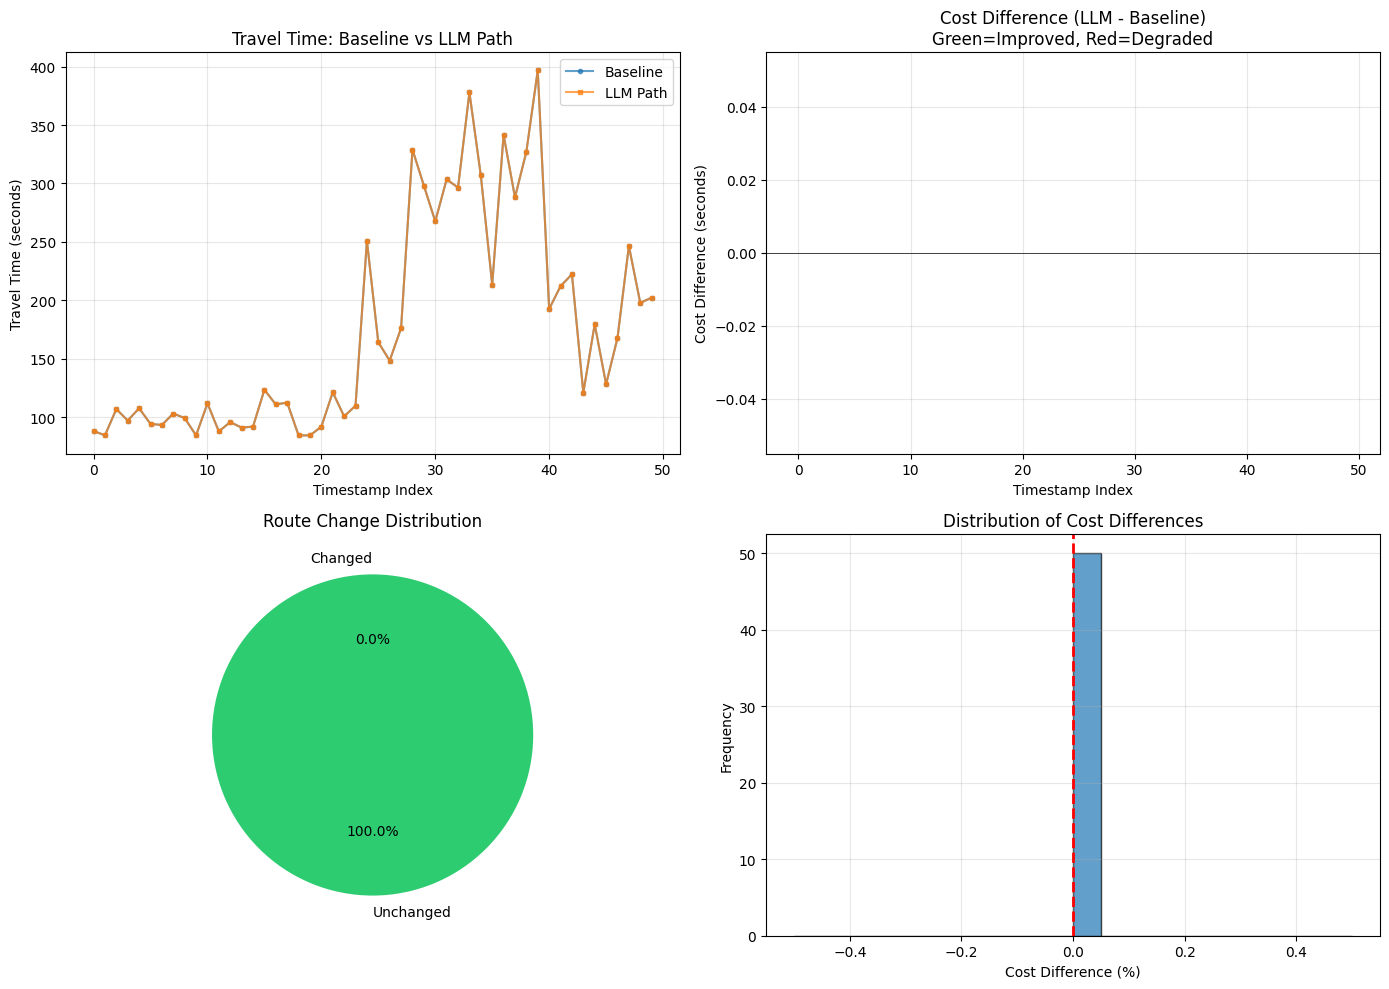


📈 Key Metrics:
   Routes where LLM improved: 0
   Routes where LLM degraded: 0
   Routes with same cost: 50


In [62]:
# Cell 22: Visualize Evaluation Results
import matplotlib.pyplot as plt

if not eval_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Travel time comparison over timestamps
    ax1 = axes[0, 0]
    ax1.plot(range(len(eval_df)), eval_df['baseline_time_s'], 
             label='Baseline', marker='o', markersize=3, alpha=0.7)
    ax1.plot(range(len(eval_df)), eval_df['llm_actual_time_s'], 
             label='LLM Path', marker='s', markersize=3, alpha=0.7)
    ax1.set_xlabel('Timestamp Index')
    ax1.set_ylabel('Travel Time (seconds)')
    ax1.set_title('Travel Time: Baseline vs LLM Path')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Cost difference over time
    ax2 = axes[0, 1]
    colors = ['green' if x < 0 else 'red' if x > 0 else 'gray' for x in eval_df['cost_diff_s']]
    ax2.bar(range(len(eval_df)), eval_df['cost_diff_s'], color=colors, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.set_xlabel('Timestamp Index')
    ax2.set_ylabel('Cost Difference (seconds)')
    ax2.set_title('Cost Difference (LLM - Baseline)\nGreen=Improved, Red=Degraded')
    ax2.grid(True, alpha=0.3)
    
    # 3. Route change distribution
    ax3 = axes[1, 0]
    changed_counts = eval_df['route_changed'].value_counts()
    labels = ['Unchanged', 'Changed']
    sizes = [changed_counts.get(False, 0), changed_counts.get(True, 0)]
    colors_pie = ['#2ecc71', '#e74c3c']
    ax3.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%', startangle=90)
    ax3.set_title('Route Change Distribution')
    
    # 4. Cost difference histogram
    ax4 = axes[1, 1]
    ax4.hist(eval_df['cost_diff_pct'], bins=20, edgecolor='black', alpha=0.7)
    ax4.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax4.set_xlabel('Cost Difference (%)')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Distribution of Cost Differences')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional stats
    print("\n📈 Key Metrics:")
    print(f"   Routes where LLM improved: {(eval_df['cost_diff_s'] < 0).sum()}")
    print(f"   Routes where LLM degraded: {(eval_df['cost_diff_s'] > 0).sum()}")
    print(f"   Routes with same cost: {(eval_df['cost_diff_s'] == 0).sum()}")
else:
    print("No evaluation data to visualize")